# QOSF batch 9 mentorship Task 1 (less-than-k)
#### Author: Miguel Ortiz

Pennylane implementation for task 1 and task 2 of QOSF task for batch 9 mentorship

**Summary:**
Implementation for task 1 **(less than k)** is based on the following paper: [Automatic Generation of an Efficient Less-Than
Oracle for Quantum Amplitude Amplification, (Sanchez-Rivero et.al)](https://arxiv.org/pdf/2303.07120.pdf), which was fun to learn more in-depth about the Grover algorithm and the challenge of creating oracles. In my submission we explore the effect of the number of grover iterations, as well as set the stage with simpler single solution oracle. For this task we basically create a less-than-k oracle and find an appropiate number of iterations, which we ought to generalize as next steps).

Task 2 **(odd-to-even)** was "easy" but I had a feeling of not being "quantum" enough as we just had to do an incomplete SWAP after the realization that you just need to turn the least significant qubit off, assuming X-gates (binary) encoding for each number. I based this only on knowledge of binary representation of numbers. Solution for task 2 is in a second notebook

Based on the previous I decided to submit task 1 as my submission for QOSF mentorship, which seemed more complete, and from which interesting insights can be derived from, as well a in-depth knowledge for grover oracles.

**Next steps:**
Ideas for improvements to reduce circuit depth of MCZ can be based on: [Programmable networks for quantum algorithms
(Schuch&Siewert)](https://arxiv.org/abs/quant-ph/0303063) and the famous [Elementary gates for quantum computation (Barenco et.al)](https://arxiv.org/pdf/quant-ph/9503016.pdf). This is because the highest cost in our circuit comes from the MCX, which along with hadmard gates is used to create a multi-qubit controlled z operation, if we are able to reduce the depth from this MCX knowning that we want a MCZ, then we can greatly reduce circuit length

## Showing the effect of phase gates on superposition in a very simple example:

We start by understanding how a Z gate can effect the phases of a superposition, as we see here, all the states which have a 1 in the first qubit get a $\pi$ phase, this control of which bits get what phase will be useful in defining a less-than-k oracle

In [5]:
import pennylane as qml
from math import pi
from qiskit.visualization import array_to_latex
import numpy as np
from qiskit.quantum_info import Statevector

num_qubits=2
dev = qml.device('default.qubit', wires=num_qubits)
@qml.qnode(dev)
def entangler_block():
    # TODO: define 
    # Return the expectation value of PauliZ for both qubits
    
    qml.Hadamard(0)
    qml.Hadamard(1)
    
    qml.Z(0)
    
    return qml.state()

Statevector(entangler_block()).draw('latex')

<IPython.core.display.Latex object>

# Showcasing single-answer Grover-Search

The main results of this section are investigation of the effect of number of grover iterations, and effectiveness of Grover search in the most simple oracle case.

The main results are the following:
- **100% success rate is not attainable for certain configurations of grover iterations**, simple exploration may indicate that this is related to $\sqrt{N}$ not being an integer number, this needs to be explored further for confirmation. However with correct estiamtion of grover iterations, we get >99% sucess probability
- As expected by standard explanations from grover search, in each grover iteration we get closer to the right answer, but then we might "overshoot"
- Execution on real quantum devices will surelly give lower success rate
- Thus, **careful prior selection of the number of grover iterations is essential**.since measurement to check intermediate results is not possible given that measurement destroys the quantum superoposition

(<Figure size 800x400 with 1 Axes>, <Axes: >)


/opt/.qbraid/environments/qbraid_000000/pyenv/lib/python3.11/site-packages/pennylane/ops/op_math/controlled_ops.py:1046: UserWarning: The control_wires keyword will be removed soon. Use wires = (control_wires, target_wire) instead. See the documentation for more information.
  warnings.warn(


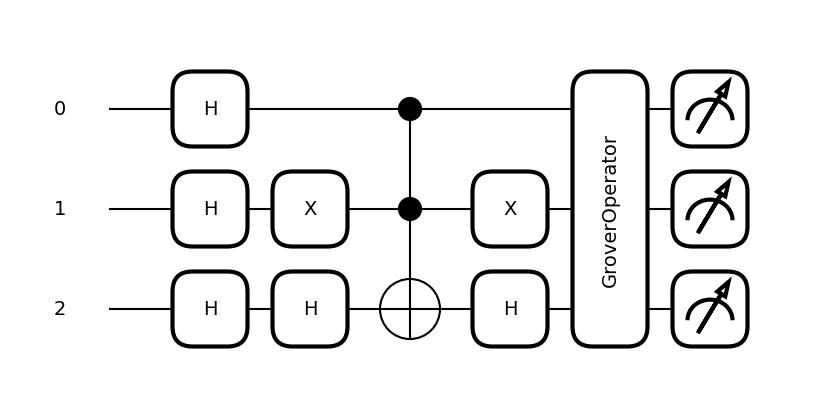

In [6]:
import pennylane as qml
from math import pi
import numpy as np

def single_number_grover(target, grover_iterations=1):
    # Adjust num_qubits to represent the range correctly
    assert target >= 3, "Grover search needs at least 2 qubits"
    
    num_qubits = int(np.ceil(np.log2(target)))
    
    def oracle():
        # Convert target to binary, padding to match num_qubits
        target_binary = bin(target)[2:][::-1]
        # Apply PauliX to invert '0' bits in the target state
        for qubit, state in enumerate(target_binary):
            if state == '0':
                qml.PauliX(wires=qubit)
        
        # Equivalent to MCZ
        qml.Hadamard(wires=num_qubits-1)
        qml.MultiControlledX(control_wires=range(num_qubits - 1), wires=num_qubits - 1)
        qml.Hadamard(wires=num_qubits-1)
        
        # Uncompute: Apply PauliX again to revert '0' bits
        for qubit, state in enumerate(target_binary):
            if state == '0':
                qml.PauliX(wires=qubit)
    
    dev = qml.device('default.qubit', wires=num_qubits)
    
    @qml.qnode(dev)
    def circuit():
        # Initialize all qubits to superposition
        for i in range(num_qubits):
            qml.Hadamard(wires=i)
        # Perform specified number of Grover iterations
        for _ in range(grover_iterations):
            oracle()
            # Apply Grover's diffusion operator
            qml.templates.GroverOperator(wires=range(num_qubits))
        
        return qml.probs(wires=range(num_qubits))
    
    return circuit

# Example usage
target_number = 5  # Example: binary '1001'
grover_iterations = 1

circuit = single_number_grover(target_number, grover_iterations)
print(qml.draw_mpl(circuit)())


In [7]:
# Initialize a matrix to store success probabilities
n_range = range(3, 64)  # Example target numbers
grover_iterations_values = range(1, 10)  # Example Grover iterations

success_prob_matrix = np.zeros((len(n_range), len(grover_iterations_values)))

# Run the simulation
for i, n in enumerate(n_range):
    for j, grover_iterations in enumerate(grover_iterations_values):
        probs = np.round(single_number_grover(n, grover_iterations=grover_iterations)(), 3)
        success_prob = float(np.max(probs))
        success_prob_matrix[i, j] = success_prob

/opt/.qbraid/environments/qbraid_000000/pyenv/lib/python3.11/site-packages/pennylane/ops/op_math/controlled_ops.py:1046: UserWarning: The control_wires keyword will be removed soon. Use wires = (control_wires, target_wire) instead. See the documentation for more information.
  warnings.warn(


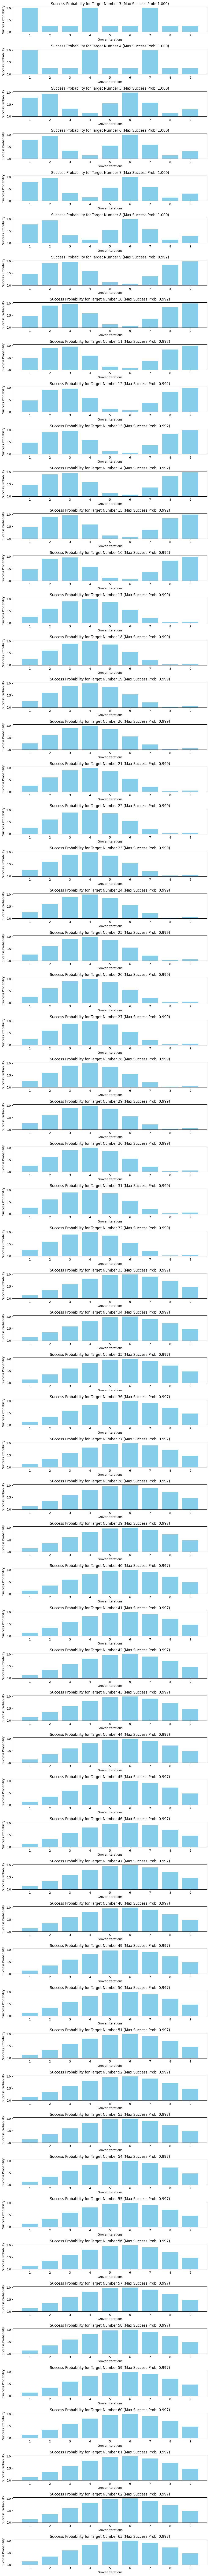

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'success_prob_matrix' is a 2D numpy array where rows correspond to target numbers (n_range)
# and columns correspond to Grover iterations (iterations_range), filled with success probabilities.

# Generate bar plots
fig, axs = plt.subplots(len(n_range), 1, figsize=(10, len(n_range) * 2))

for i, n in enumerate(n_range):

    axs[i].bar(grover_iterations_values, success_prob_matrix[i], color='skyblue')  # Adjusted index for n_range starting at 3
    # Include the max success probability in the title, rounded to three decimal places
    # Calculate the maximum success probability in the entire matrix
    max_success_prob = np.max(success_prob_matrix[i])

    axs[i].set_title(f'Success Probability for Target Number {n} (Max Success Prob: {max_success_prob:.3f})')
    axs[i].set_xlabel('Grover Iterations')
    axs[i].set_ylabel('Success Probability')
    axs[i].set_xticks(grover_iterations_values)

plt.tight_layout()
plt.show()


# Less than k oracle

In summary, the process for solving the task with an arbitraty k and and arbitrary list:

- Definition of the number of grover iterations (hard-coded for now)
- Definition of oracle circuit based on the paper [Automatic Generation of an Efficient Less-Than
Oracle for Quantum Amplitude Amplification, (Sanchez-Rivero et.al)](https://arxiv.org/pdf/2303.07120.pdf)
- Selection of numbers based on filter by high probability from sampled states (i.e sample, then keep number with high probability only, then filter the for the numbers that appear in the high probability sampled states)

Main idea of oracle design:

Of great interest is the idea behind the oracle design, in summary, the oracle goes from most-significant bit to less significant, marking the correct states to be amplified, we break this down in the following steps:

- First, we refer back to our first example of the effect of a single Z gate on a two-qubit superposition. Which allowed to mark all states with $|1>$ on a qubit with an specific phase, in particular, marking all $|1x>$ ($x$ being either 1 or 0), this is also easy to generalize to more than two qubits. 
- It is easy to note that adding X gates around the Z gate, we can get all the $|0x>$ states with an specific phase. We'll call this the $XZX$ operator, and then we'll use a controlled XZX operator.
- Let $b_i$ be the i-th binary number in the representation of k, with $b_n$ being the most significant bit.
- In the first steps of the oracle, we inspect the most significant bit of our number, if $b_n$ is 1, this means that all numbers with 0 in this bit are smaller than k, thus we apply an $XZX$ gate.
- By doing a controlled operations, we can apply the $XZX$ operator to the correct states by moving from most signficant to less significant qubits, marking only the correct states.
- Note that for the control to be correct, in states in which b_i is 0, we apply a $X$ gate to the states (which gets cancelled at the end$. This can be a bit confusing (pun intented), but we display in a simple example for k=5 how this works in detail. This is a simple but good contribution since the original paper doesn't explain this with much care.


Main results:
- Rotation angle for multi-answer grover (in specific for this less-than-k) oracle is much higher, and thus a single grover iteration can get us much closer to the answer (or very far from it), much unlike the behaviour from single answer grover where we slowly get closer to the answer.
- +95% sucess can be attained from correct selection of grover iteration
- Diffusion operator (reflection around the mean) doesn't attain any amplitude amplification in cases of equilibrated less than k tasks. For example when defining a less than 4 oracle with 8 possible states, amplitudes stay unchanged after difussion operator. This means that we might desire to increase the number of qubits to be used to be higher than just `int(np.ceil(np.log2(k)))`

To illustrate this we go through several sections:

- Definition of `less_than_grover` function and vizualization of circuit
- Showcasing oracle design logic with k=5
- Inspecting intermediate phases and amplitudes (k=11)
- Vizualization of effect of iterations (k=11)
- No amplification for 50-50 oracles (k=4)
- 100% of accuracy for bigger state size and a single iteration (with previous zero amplification) (k=4)
- Task solution using pre-defined general oracle
- Initial Solution for suggested example (k=7) with 68% accuracy
- Final Solution for suggested example (k=7) with 99% accuracy
- Vizualization of effect of iterations for k=7

Next steps:
- Understand an generalize prior selection of grover iterations for less-than-k oracle

# Definition of general oracle circuit

(<Figure size 2400x500 with 1 Axes>, <Axes: >)

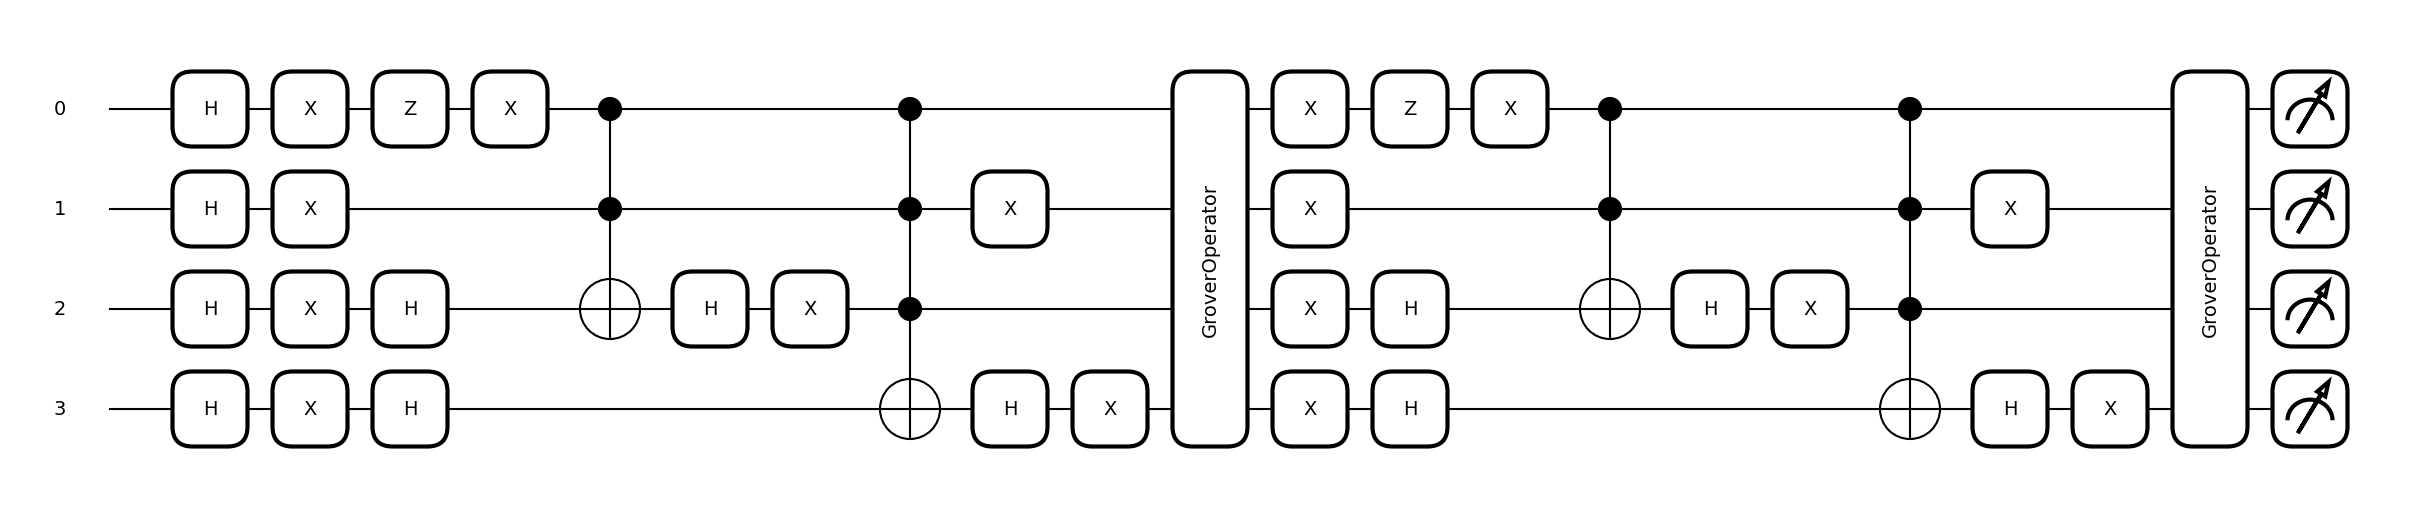

In [29]:
import pennylane as qml
from math import pi
from qiskit.visualization import array_to_latex
import numpy as np


def less_than_grover(target, states_size=None, grover_iterations=1, return_state=False):
    if states_size is None:
        states_size = target
    num_qubits = int(np.ceil(np.log2(states_size)))
    
    assert k >= 3, "Grover search needs at least 2 qubits"
    

    def oracle():
        binary_k = bin(target)[2:].zfill(num_qubits)
        
        most_significant_qubit = num_qubits - 1
        
        
        if binary_k[0] == '0':
            qml.PauliX(0)    
        else:
            qml.PauliX(0)    
            qml.PauliZ(0)    
            qml.PauliX(0)    
            
        # Iterate from n-2 most significant qubit to less significant qubit
        for i in range(1, most_significant_qubit + 1):
            bin_i = binary_k[i]
            #print(f"{i=} {bin_i=}")
            
            if bin_i ==  '0':
                qml.PauliX(i)
                pass
            else:
                qml.PauliX(i)
                
                qml.Hadamard(i)
                
                control_wires = range(0, i)
                
                qml.MultiControlledX(control_wires=control_wires, wires=i)
                qml.Hadamard(i)

                qml.PauliX(i)

        for i, bin_i in enumerate(binary_k):
            if bin_i == '0':
                qml.PauliX(i)
                
    dev = qml.device('default.qubit', wires=num_qubits)
    @qml.qnode(dev)
    def circuit():
                    
        qubits = list(range(num_qubits))

        most_significant_qubit = num_qubits - 1
        
        for i in range(num_qubits):
            qml.Hadamard(wires=i)
        
        for _ in range(grover_iterations):
            oracle()
            qml.templates.GroverOperator(wires=qubits)
        
        if return_state:
            print("Returning state :) ")
            return qml.state()
        
        return qml.probs(wires=qubits)
    
    return circuit

circuit = less_than_grover(11, grover_iterations=2, return_state=False)

qml.draw_mpl(circuit)()

# Showcasing oracle design logic with k=5:

Disregarding the normalization constant for simplicity,

In our first step, we use $XZX$ marking all the states 0, 1, 2, and 3


$|000\rangle$ (or $|0\rangle$ in decimal) -> $-|000\rangle$ (Applying $XZX$)

$|001\rangle$ (or $|1\rangle$ in decimal) -> $-|001\rangle$ (Applying $XZX$)

$|010\rangle$ (or $|2\rangle$ in decimal) -> $-|010\rangle$ (Applying $XZX$)

$|011\rangle$ (or $|3\rangle$ in decimal) -> $-|011\rangle$ (Applying $XZX$)

$|100\rangle$ (or $|4\rangle$ in decimal) -> $|100\rangle$ (No change for states beyond 3)

$|101\rangle$ (or $|5\rangle$ in decimal) -> $|101\rangle$

$|110\rangle$ (or $|6\rangle$ in decimal) -> $|110\rangle$

$|111\rangle$ (or $|7\rangle$ in decimal) -> $|111\rangle$

2. We then apply an $X$ operation on the second qubit, obtaining the following states:

$-|000\rangle$ -> $-|010\rangle$ (Flipping the second qubit)

$-|001\rangle$ -> $-|011\rangle$ (Flipping the second qubit)

$-|010\rangle$ -> $-|000\rangle$ (Flipping the second qubit)

$-|011\rangle$ -> $-|001\rangle$ (Flipping the second qubit)

$|100\rangle$ -> $|110\rangle$ (Flipping the second qubit)

$|101\rangle$ -> $|111\rangle$ (Flipping the second qubit)

$|110\rangle$ -> $|100\rangle$ (Flipping the second qubit)

$|111\rangle$ -> $|101\rangle$ (Flipping the second qubit)

3. On the final wire, we apply a CCXZX, it can be easily seen that this will affect only $|110\rangle$, which we know is our original 4 state, which is the only state that is still missing a $\pi$ phase.

(<Figure size 1100x400 with 1 Axes>, <Axes: >)

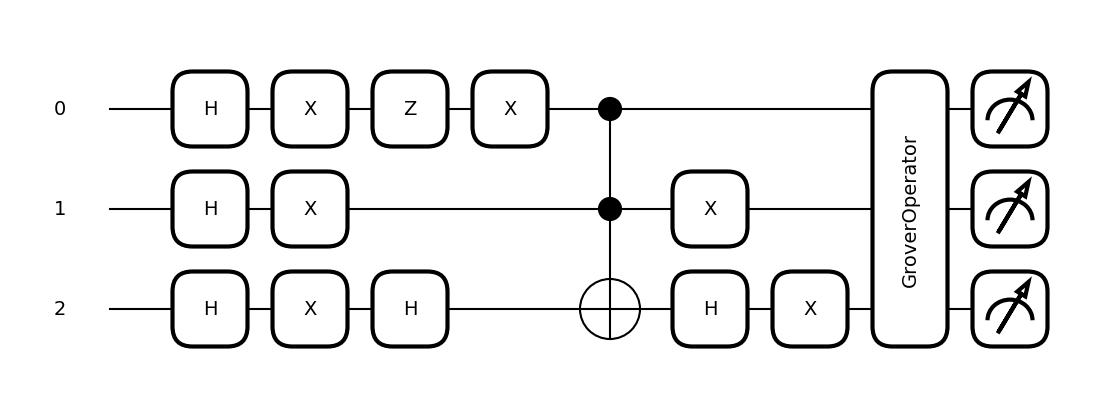

In [53]:
circuit = less_than_grover(5, grover_iterations=1, return_state=False)

qml.draw_mpl(circuit)()

# Inspecting intermediate phases and amplitudes (k=11)

In [24]:
circuit = less_than_grover(11, grover_iterations=2, return_state=True)

state = circuit().round(2)
for i, x in enumerate(state):
    print(bin(i)[2:].zfill(4), x)
    

Returning state :) 
0000 (-0.3+0j)
0001 (-0.3+0j)
0010 (-0.3+0j)
0011 (-0.3+0j)
0100 (-0.3+0j)
0101 (-0.3+0j)
0110 (-0.3+0j)
0111 (-0.3+0j)
1000 (-0.3+0j)
1001 (-0.3+0j)
1010 (-0.3+0j)
1011 (0.08+0j)
1100 (0.08+0j)
1101 (0.08+0j)
1110 (0.08+0j)
1111 (0.08+0j)


/opt/.qbraid/environments/qbraid_000000/pyenv/lib/python3.11/site-packages/pennylane/ops/op_math/controlled_ops.py:1046: UserWarning: The control_wires keyword will be removed soon. Use wires = (control_wires, target_wire) instead. See the documentation for more information.
  warnings.warn(


# Vizualization of effect of iterations (k=11)

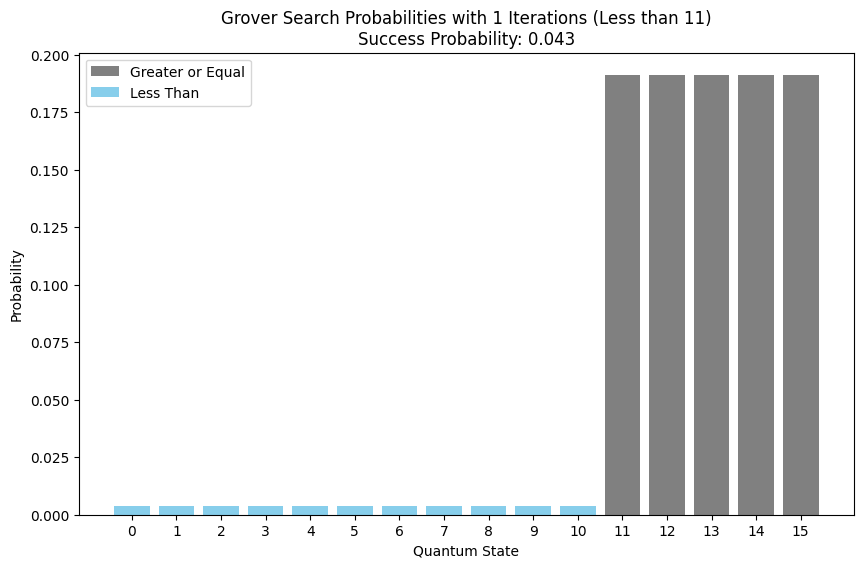

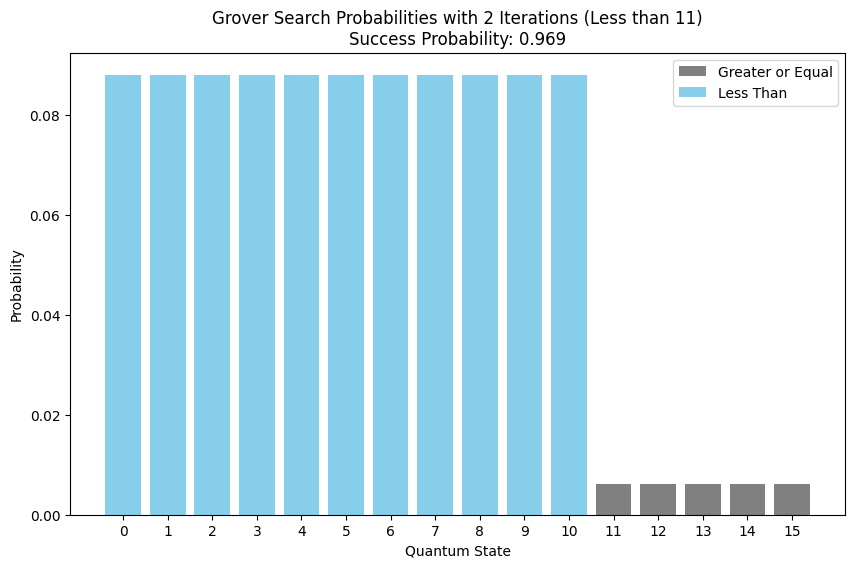

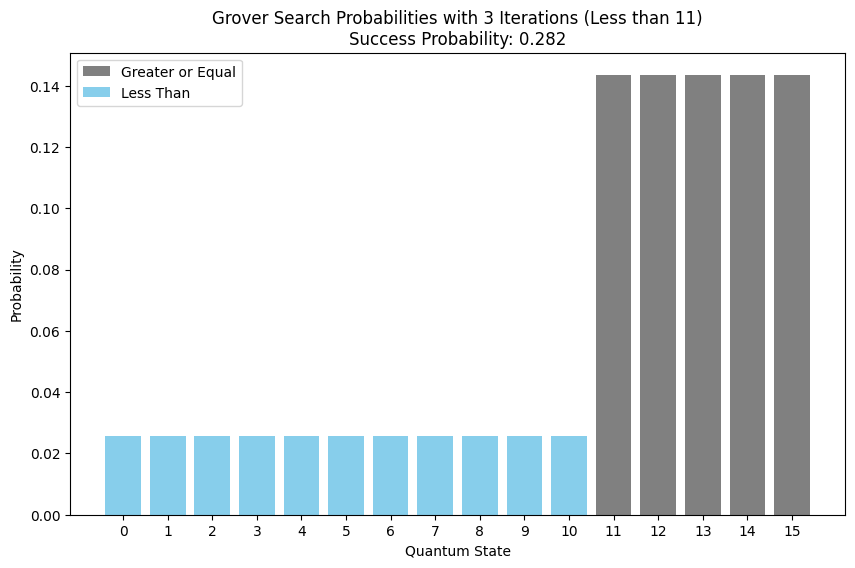

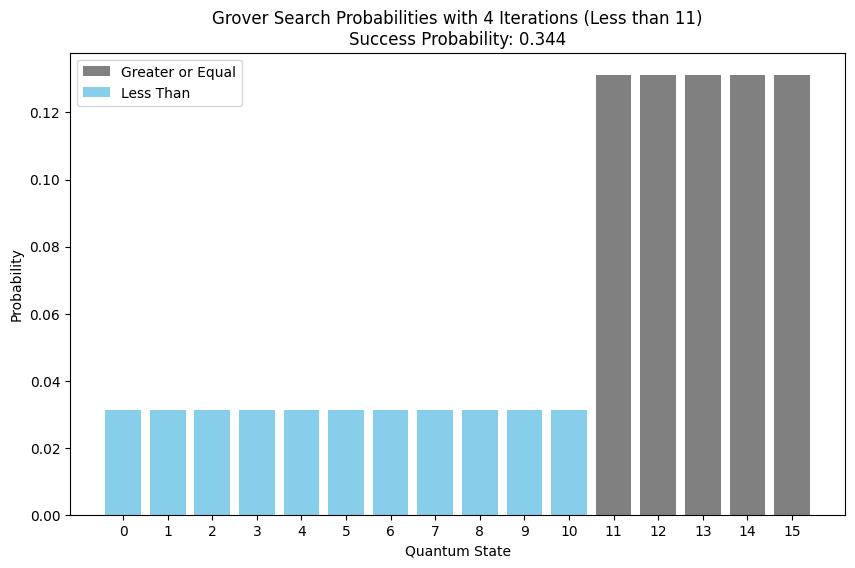

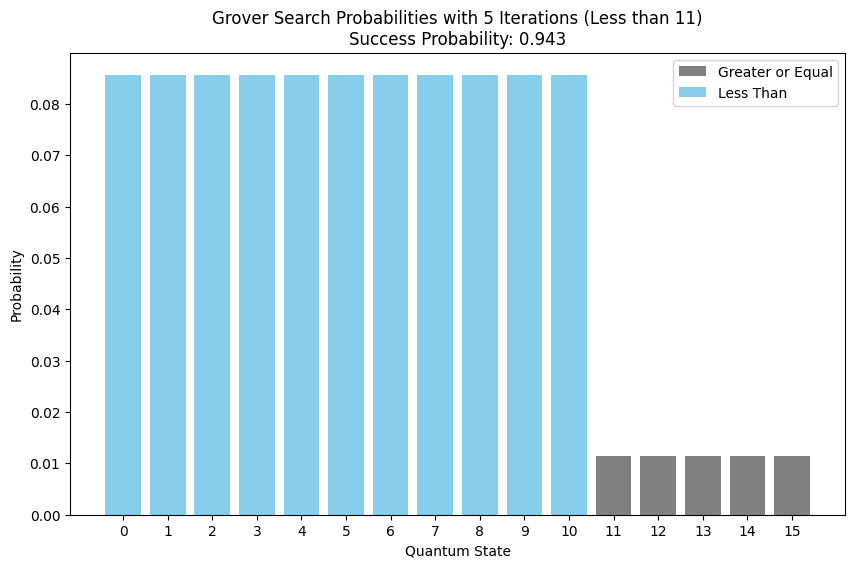

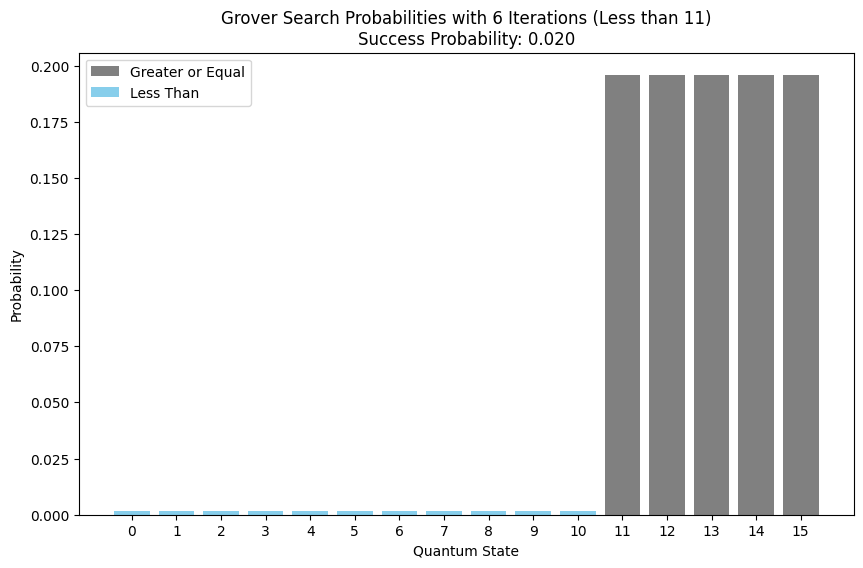

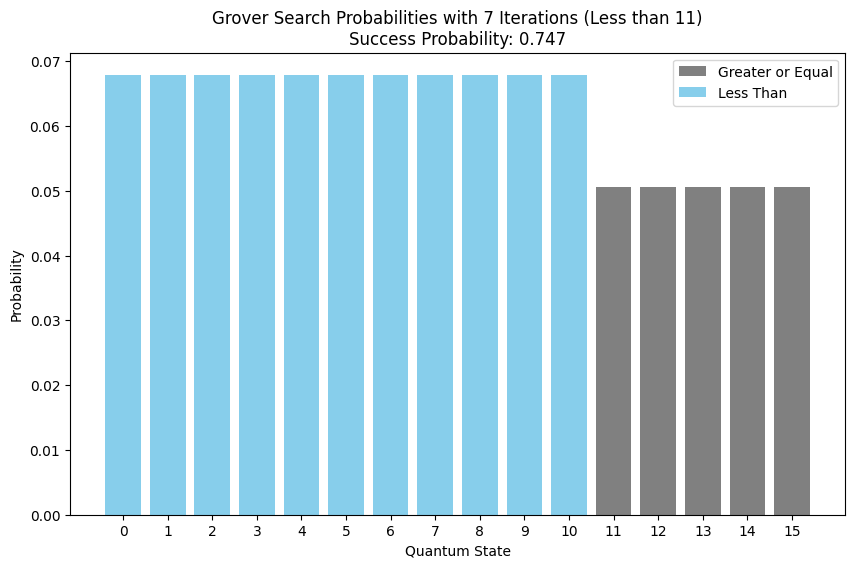

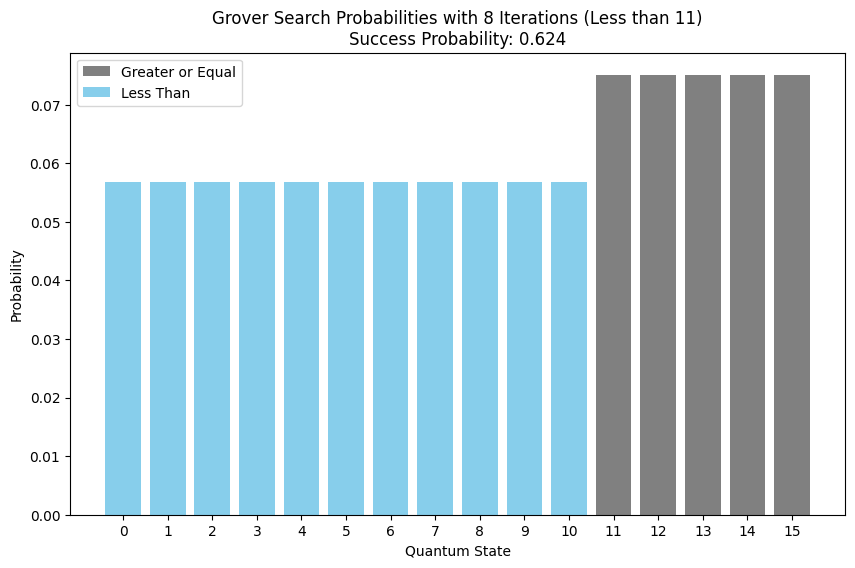

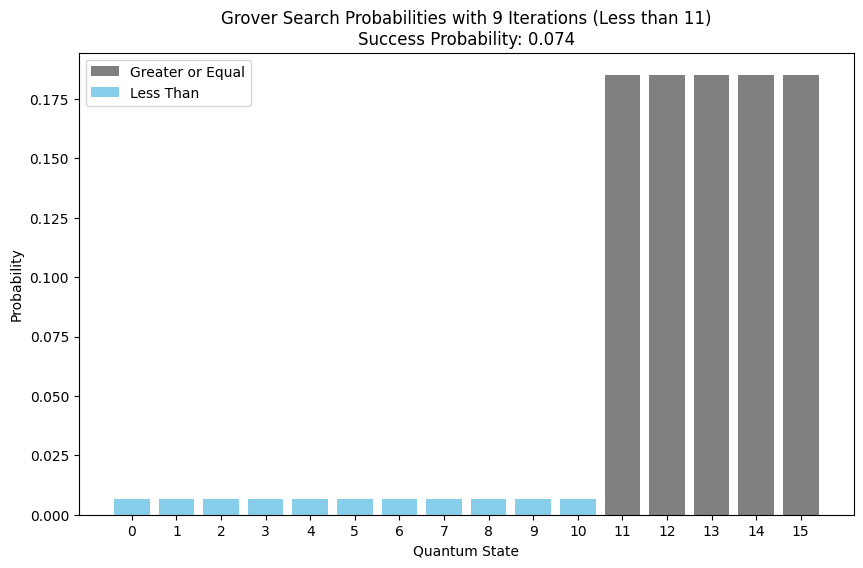

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def plot_less_than_k_probs(probs, k):
    # Calculate the number of qubits based on k and use it to determine the range of possible numbers
    num_states = len(probs)
    state_labels = range(num_states)
    
    # Determine which states are less than k
    less_than_states = [state for state in state_labels if state < k]
    
    correct_probs = np.sum(probs[:len(less_than_states)])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(state_labels, probs, color='grey', label='Greater or Equal')
    plt.bar(less_than_states, probs[:len(less_than_states)], color='skyblue', label='Less Than')
    
    plt.xlabel('Quantum State')
    plt.ylabel('Probability')
    plt.title(f'Grover Search Probabilities with {grover_iterations} Iterations (Less than {k})\n'
              f'Success Probability: {correct_probs:.3f}')
    plt.xticks(state_labels)
    plt.legend()
    plt.show()
    
# Assuming 'grover_iterations_range' is a list of the number of iterations you want to test
# And 'less_than_grover' is your function returning the probabilities array from the Grover search
# 'k' is the threshold for the less than condition

grover_iterations_range = range(1, 10)  # Example range of Grover iterations
k = 11  # Example threshold for the less than condition
n = 16
    
for grover_iterations in grover_iterations_range:
    
    probs = less_than_grover(k, n, grover_iterations=grover_iterations)()
    # Assuming probs is a numpy array of probabilities for each state
    
    plot_less_than_k_probs(probs, k)

# No amplification for 50-50 oracles (k=4)

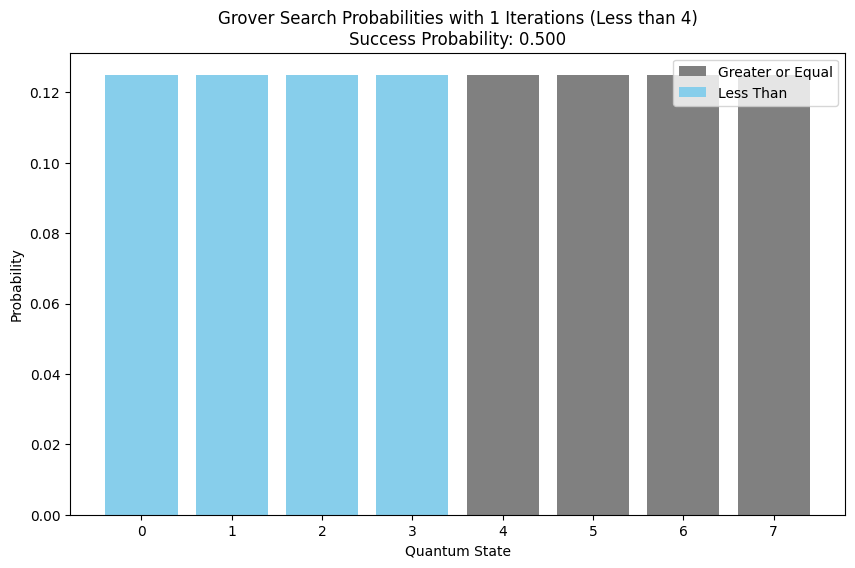

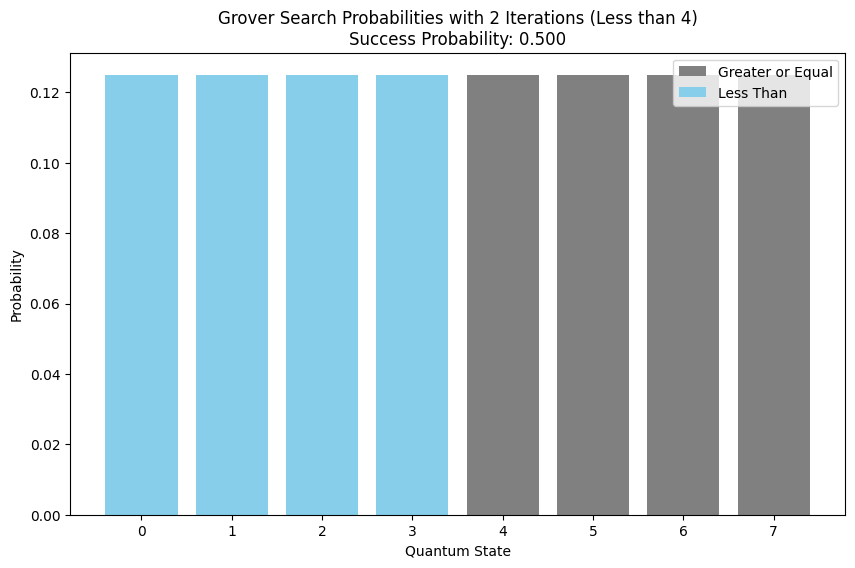

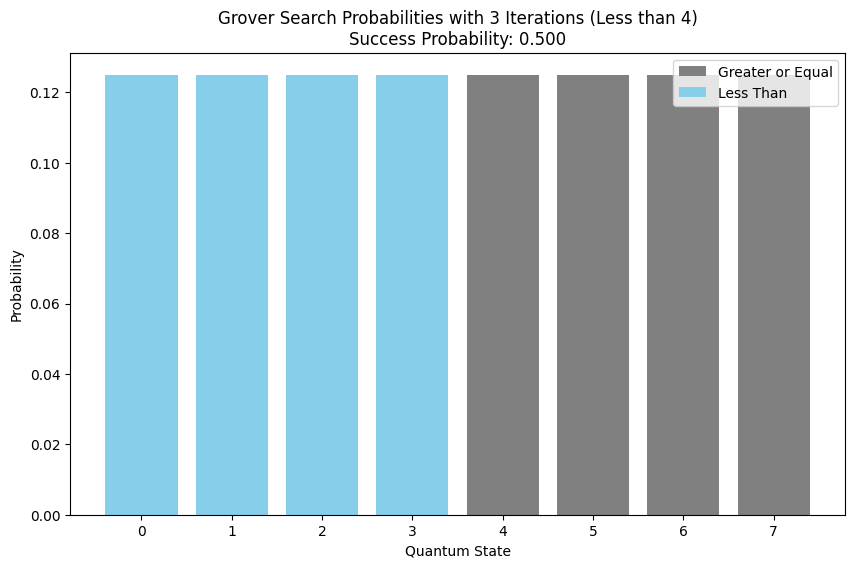

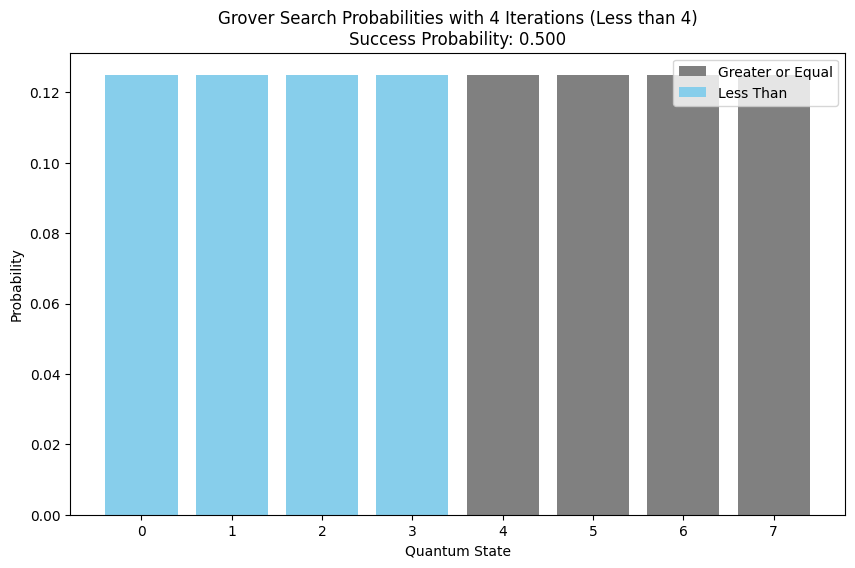

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'grover_iterations_range' is a list of the number of iterations you want to test
# And 'less_than_grover' is your function returning the probabilities array from the Grover search
# 'k' is the threshold for the less than condition

grover_iterations_range = [1, 2, 3, 4]  # Example range of Grover iterations
k = 4  # Example threshold for the less than condition    
n = 8
for grover_iterations in grover_iterations_range:
    
    probs = less_than_grover(k, n, grover_iterations=grover_iterations)()
    # Assuming probs is a numpy array of probabilities for each state
    
    plot_less_than_k_probs(probs, k)

# 100% of accuracy for bigger state size and a single iteration (with previous zero amplification) (k=4)

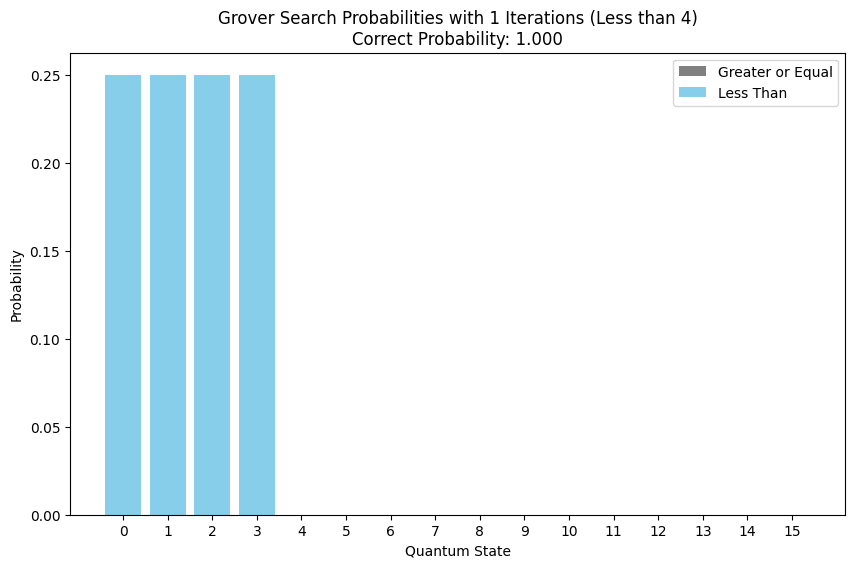

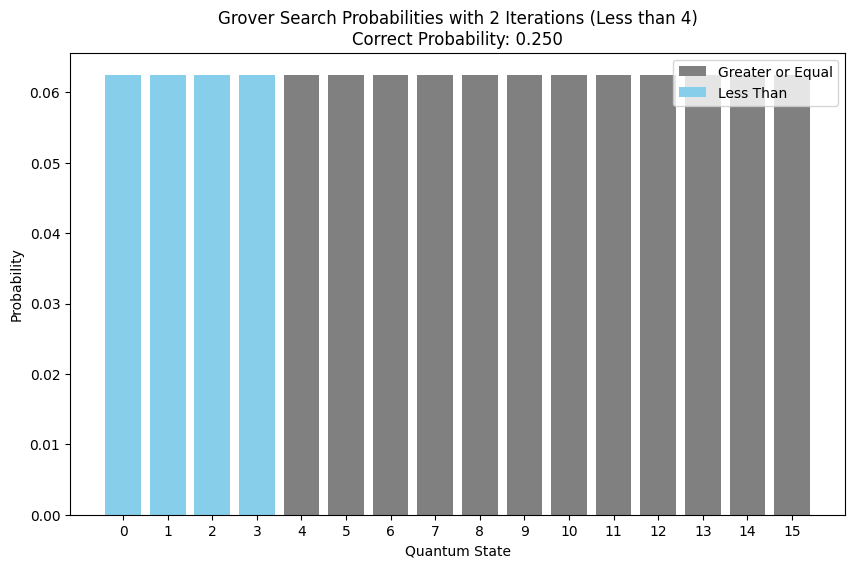

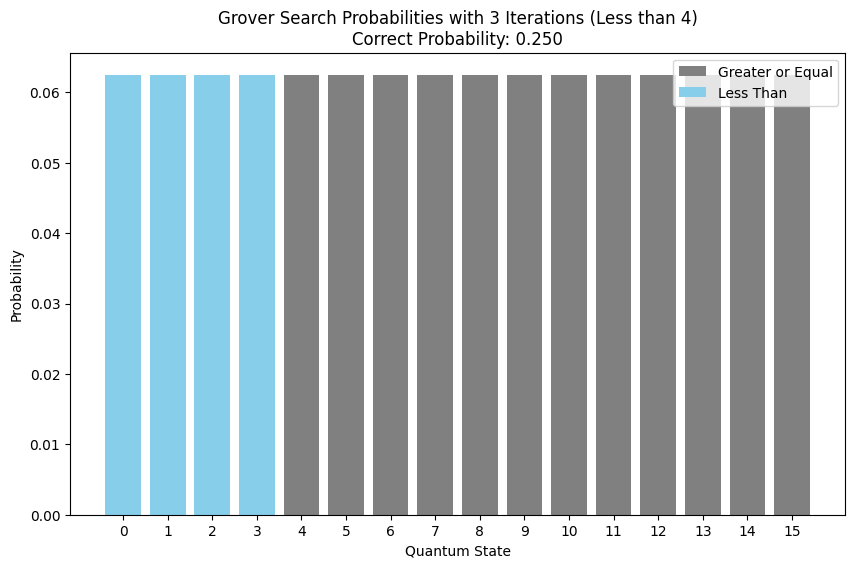

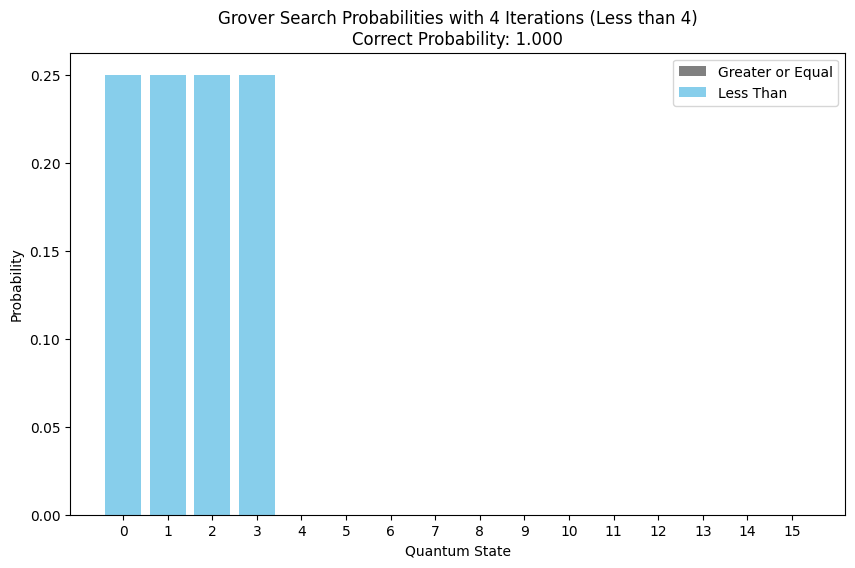

In [249]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'grover_iterations_range' is a list of the number of iterations you want to test
# And 'less_than_grover' is your function returning the probabilities array from the Grover search
# 'k' is the threshold for the less than condition

grover_iterations_range = [1, 2, 3, 4]  # Example range of Grover iterations
k = 4  # Example threshold for the less than condition
n = 16 # Use to define number of qubits
    
for grover_iterations in grover_iterations_range:
    
    probs = less_than_grover(k, n, grover_iterations=grover_iterations)()
    # Assuming probs is a numpy array of probabilities for each state
    
    plot_less_than_k_probs(probs, k)

# Task solution using pre-defined general oracle

In [50]:
def less_than_k(k: int, list_n: list[int], grover_iterations = 1):
    """
    k : integer value that is the positive number to compare in list_n,
    list_n : integer list that has positive numbers.
    Return the numbers that are in list_n and are less than k 
    """
    
    n = k * 2
    total_states = int(np.ceil(np.log2(n)))
    # TODO: improve pre-selection of grover iterations
    #grover_iterations = np.sqrt(total_states / k) 
    #grover_iterations = int(np.round(grover_iterations))
    
    circuit = less_than_grover(k, n, grover_iterations=grover_iterations)
    
    qml.draw_mpl(circuit)()
    
    probs = circuit()
    
    plot_less_than_k_probs(probs, k)
    
    selected = np.argwhere(probs == np.max(probs)).flatten().tolist()
    
    result = [x for x in list_n if x in selected]
    
    return result
    
    

# Initial Solution for suggested example (k=7) with 68% accuracy

/opt/.qbraid/environments/qbraid_000000/pyenv/lib/python3.11/site-packages/pennylane/ops/op_math/controlled_ops.py:1046: UserWarning: The control_wires keyword will be removed soon. Use wires = (control_wires, target_wire) instead. See the documentation for more information.
  warnings.warn(


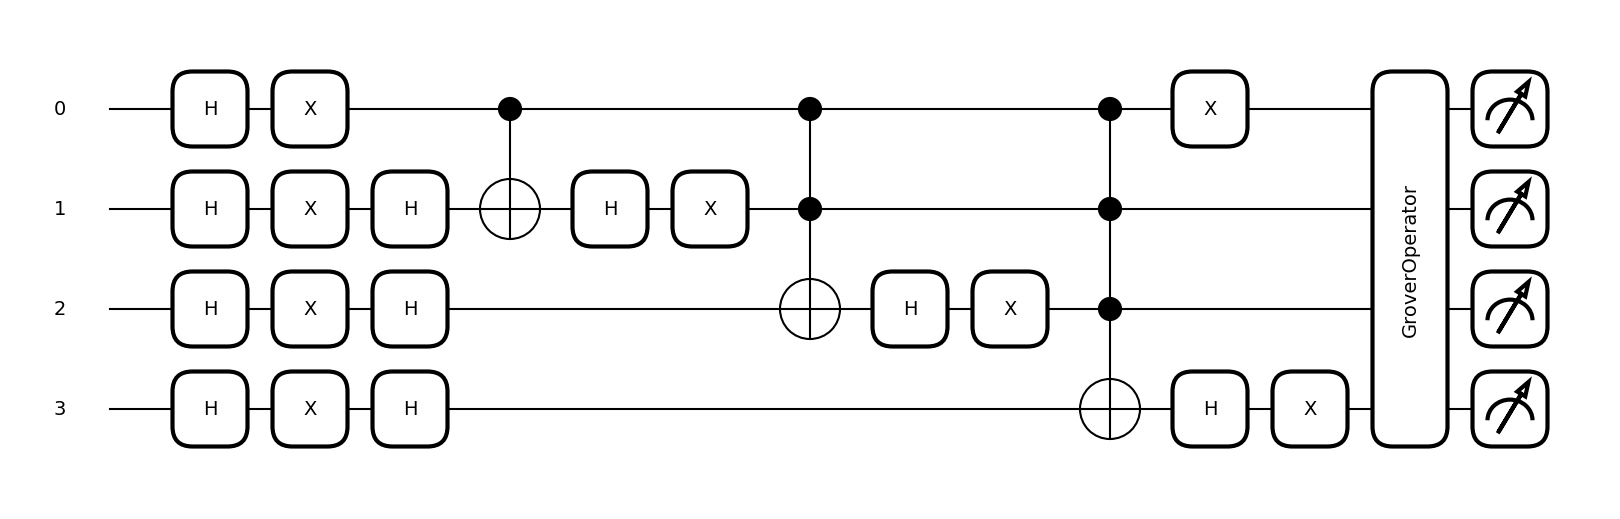

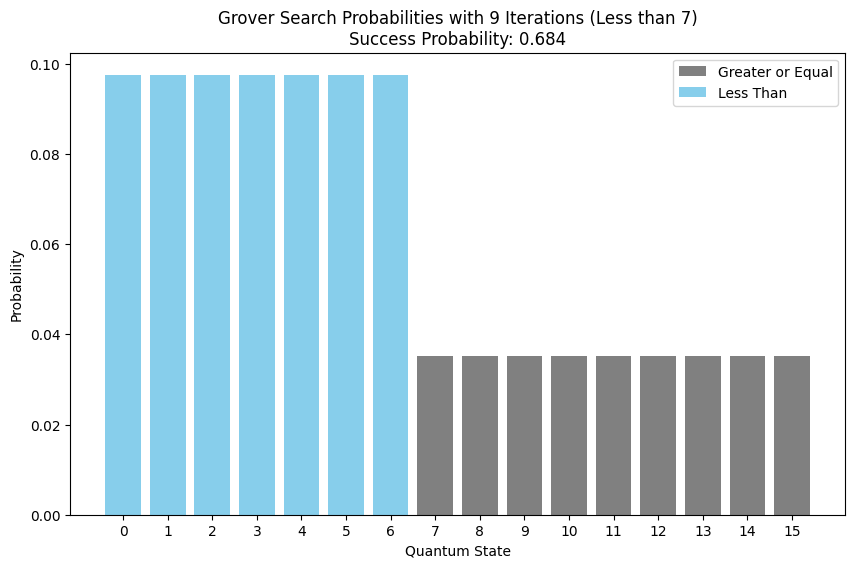

[4, 1, 6]


In [51]:
A = less_than_k(7,list_n=[4,9,11,14,1,13,6,15])

print(A)

# Final Solution for suggested example (k=7) with 99% accuracy

/opt/.qbraid/environments/qbraid_000000/pyenv/lib/python3.11/site-packages/pennylane/ops/op_math/controlled_ops.py:1046: UserWarning: The control_wires keyword will be removed soon. Use wires = (control_wires, target_wire) instead. See the documentation for more information.
  warnings.warn(


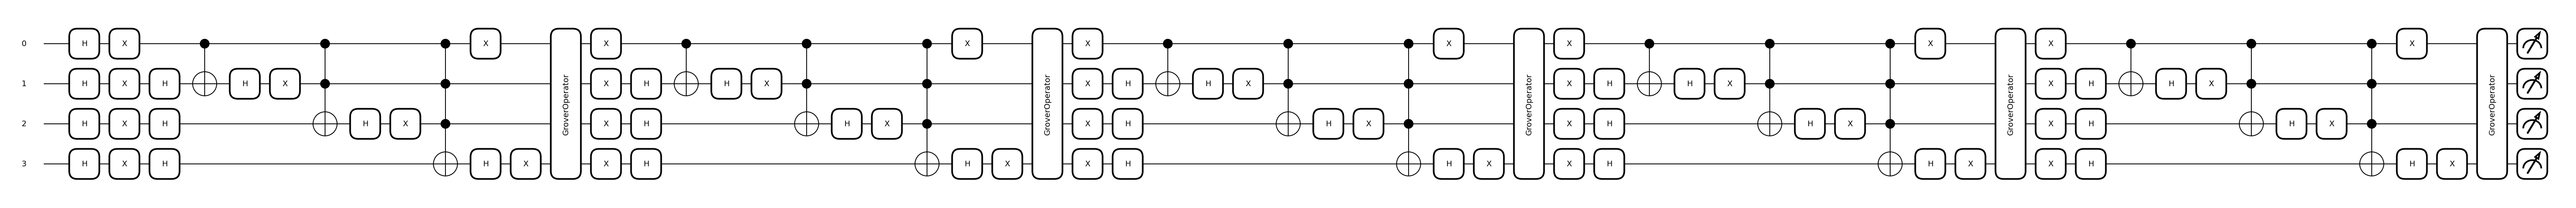

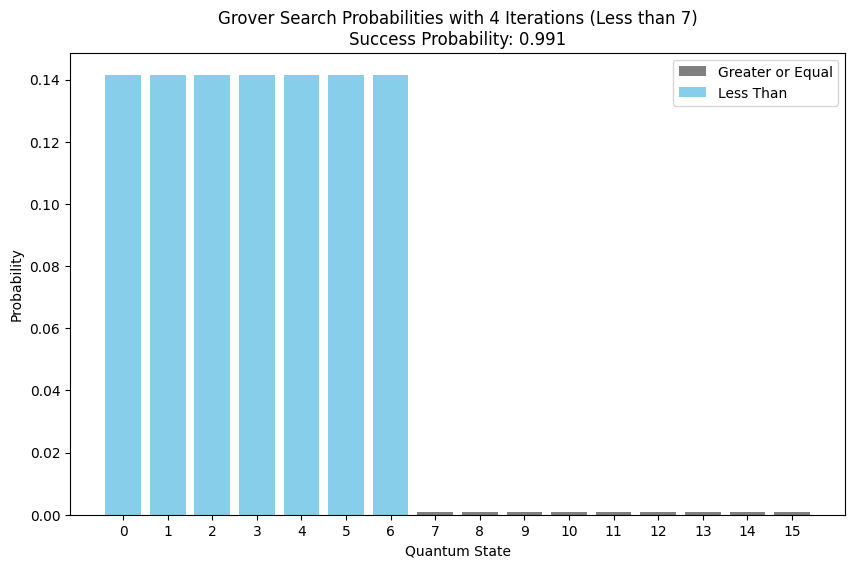

[4, 1, 6]


In [43]:
A = less_than_k(7,list_n=[4,9,11,14,1,13,6,15], grover_iterations=5)

print(A)

# Vizualization of effect of iterations for k=7

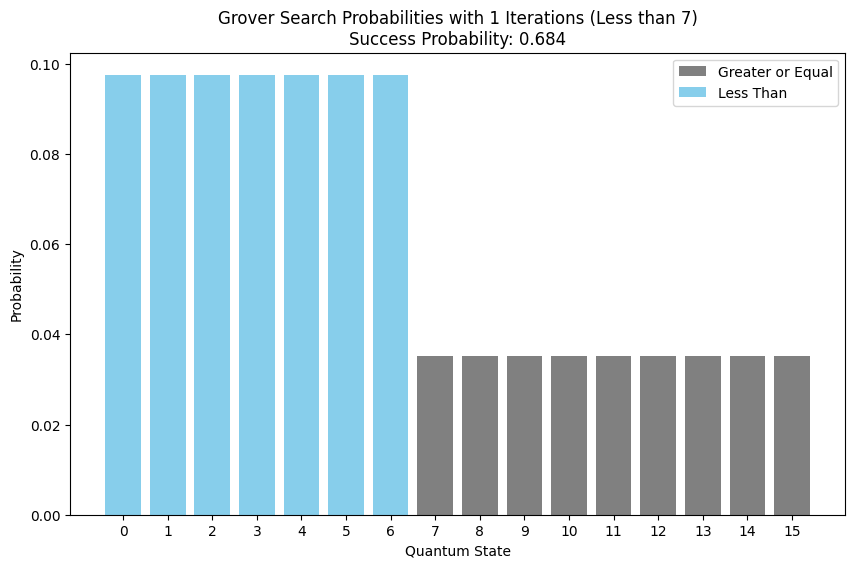

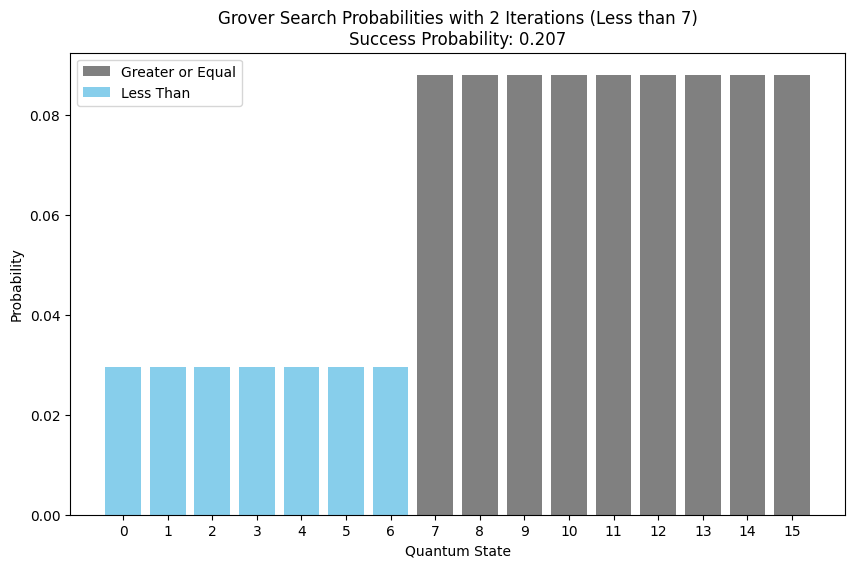

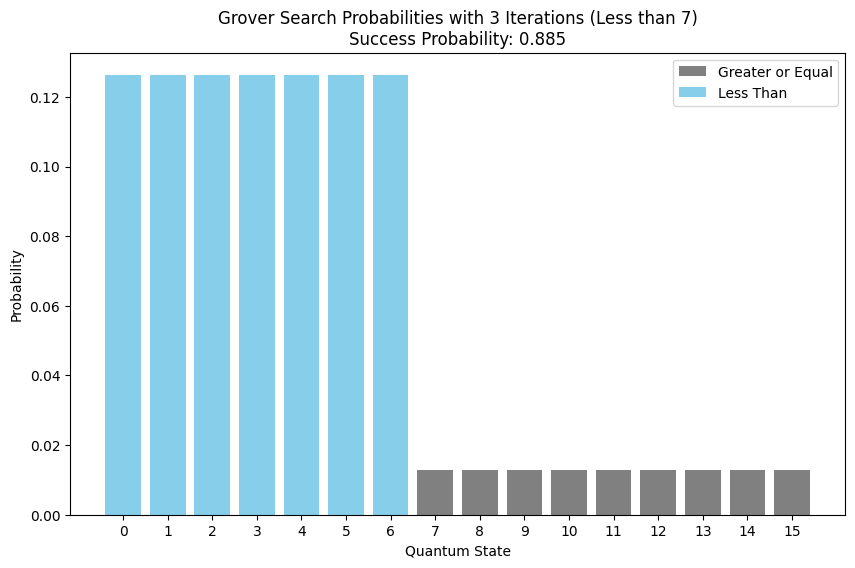

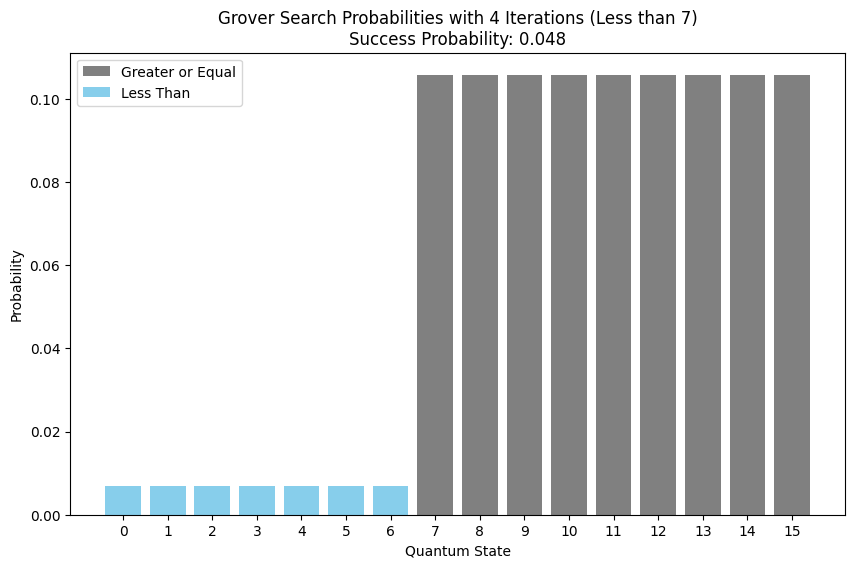

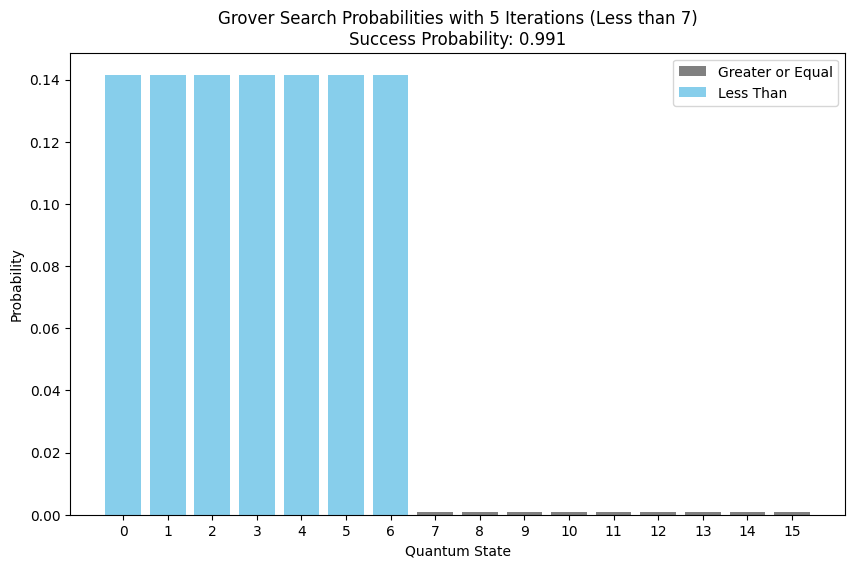

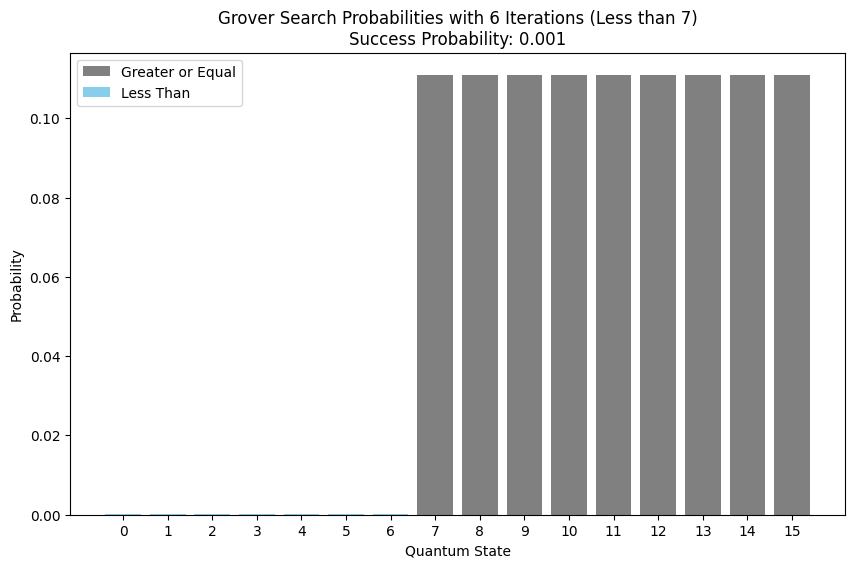

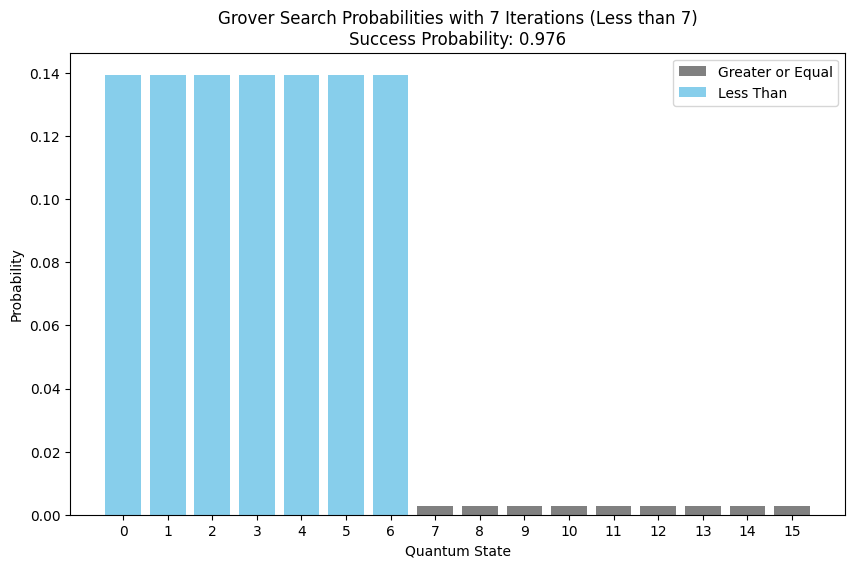

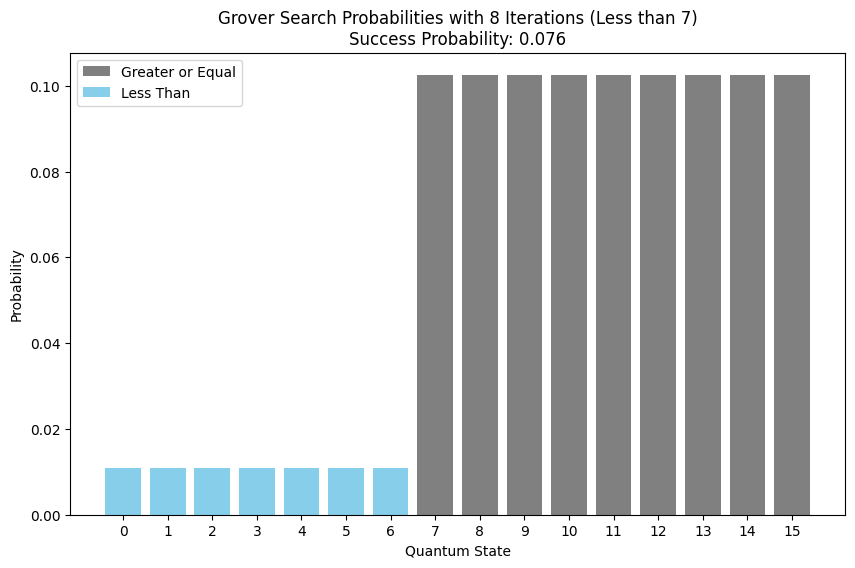

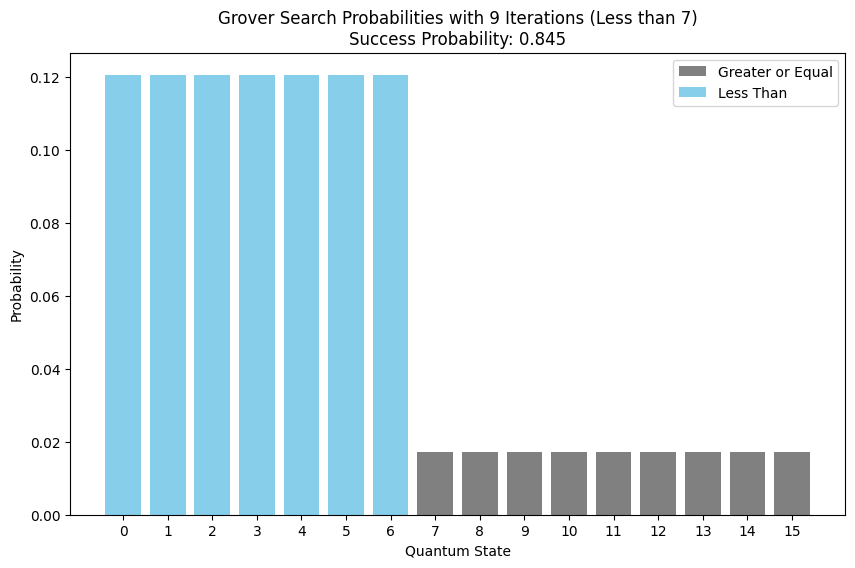

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'grover_iterations_range' is a list of the number of iterations you want to test
# And 'less_than_grover' is your function returning the probabilities array from the Grover search
# 'k' is the threshold for the less than condition

grover_iterations_range = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # Example range of Grover iterations
k = 7  # Example threshold for the less than condition
n = 16 
for grover_iterations in grover_iterations_range:
    
    probs = less_than_grover(k, n, grover_iterations=grover_iterations)()
    # Assuming probs is a numpy array of probabilities for each state
    
    plot_less_than_k_probs(probs, k)